In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
import random


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
source_dir = ('/kaggle/input' if os.path.exists('/kaggle') else os.environ.get('KAGGLE_DATA')) + '/digit-recognizer'
for dirname, _, filenames in os.walk(source_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [5]:
train_df = pd.read_csv(source_dir + '/train.csv')

<Axes: xlabel='label'>

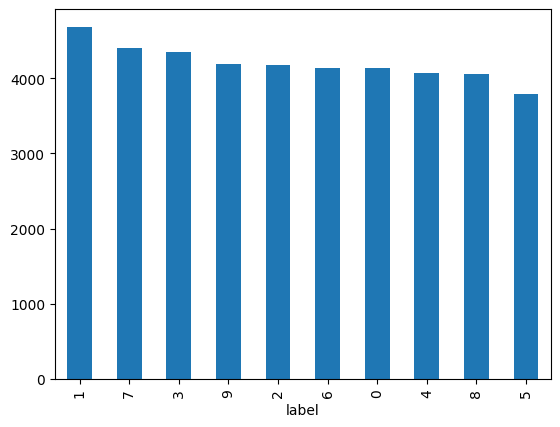

In [4]:
train_df['label'].value_counts().plot.bar()

In [6]:
torch.from_numpy(train_df.filter(train_df.columns[1:]).iloc[0].values).reshape(28, 28).shape

torch.Size([28, 28])

In [7]:
train_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


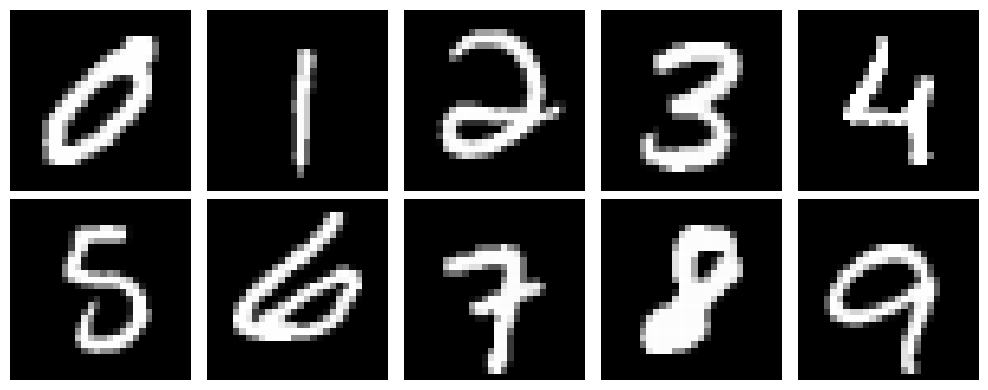

In [8]:
images = train_df.sample(frac=1).reset_index(drop=True).groupby(by='label').first().reset_index(drop=False).filter(train_df.columns[1:]).values.reshape(10, 28, 28)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout() 
plt.show()

In [9]:
label = torch.tensor(train_df['label'])
train = torch.tensor(np.array(train_df.drop(['label'], axis = 1)), dtype=torch.float32).reshape(len(train_df), 1, 28, 28)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train, label ,test_size = 0.20,random_state = 42, stratify=label)
len(X_train), len(X_val), len(y_train), len(y_val)

(33600, 8400, 33600, 8400)

9


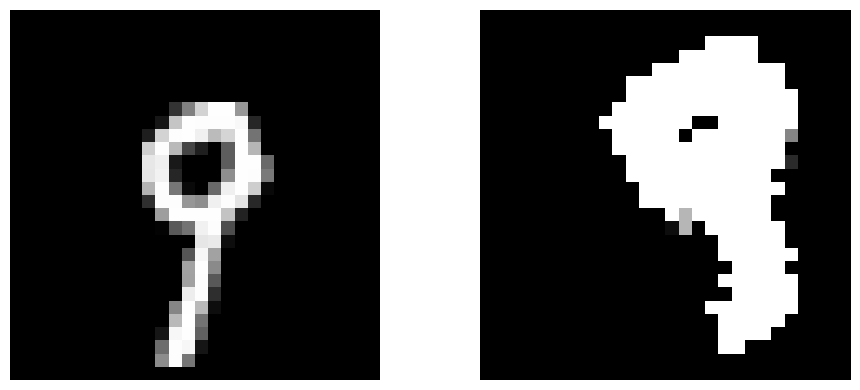

In [11]:
index = random.randint(0, len(X_train))
image =  X_train[index]
print(y_train[index].item())

# Define transformations
transform = v2.Compose([# Convert image to PyTorch tensor,
    v2.RandomResizedCrop(scale=(0.7, 1), size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.3),
    v2.Normalize((0,), (1,)),
    v2.RandomApply([v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.1)], p=0.6),
    v2.RandomAffine(30, scale=(0.95, 1))
])

# Assuming 'image' is your 28x28 image
processed_image = transform(image)
images = [image, processed_image]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout() 
plt.show()

In [37]:
from transformers import AutoModelForSequenceClassification
from transformers import ResNetConfig, ResNetModel
from transformers import AutoImageProcessor, ResNetForImageClassification

#model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=10, ignore_mismatched_sizes=True)
# Initializing a ResNet resnet-50 style configuration
configuration = ResNetConfig(num_channels=1, num_labels=10, device='cuda')

# Initializing a model (with random weights) from the resnet-50 style configuration
model = ResNetForImageClassification(configuration).to('cuda')

#model.config
#model = AutoModelForSequenceClassification.from_pretrained("microsoft/resnet-50", num_labels=10)

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define custom dataset class
class DigitImageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = (self.data[idx], self.labels[idx])
        return sample

# Assuming you have your data and labels in variables 'data' and 'labels'
# Create an instance of CustomDataset
dataset = DigitImageDataset(X_train, y_train)

# Define batch size
batch_size = 32

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for x1, x2 in dataloader:
    break

In [39]:
train_dataloader = DataLoader(DigitImageDataset(X_train, y_train), batch_size=64)
val_dataloader = DataLoader(DigitImageDataset(X_val, y_val), batch_size=32)

In [56]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss().to('cuda')


In [57]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [62]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = inputs.to('cuda')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs).logits

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [60]:
loss_fn

CrossEntropyLoss()

In [64]:
from  datetime import datetime
from torch.utils.tensorboard import SummaryWriter
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/digits_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


RuntimeError: 0D or 1D target tensor expected, multi-target not supported